In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.applications import EfficientNetV2B0
from keras._tf_keras.keras.applications.efficientnet_v2 import preprocess_input
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from keras._tf_keras.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.models import load_model
import matplotlib.pyplot as plt
from keras._tf_keras.keras.preprocessing import image

In [2]:
# Các thư mục chứa hình ảnh
categories = ['Vú sữa hoàng kim', 'Sơ ri', 'Nha đam', 'Cóc', 'Táo', 'Bơ',
              'Chuối', 'Chi thanh mai', 'Ớt chuông', 'Cau', 'Khế tàu', 'Khổ qua rừng', 'Cherry đen', 'Lý chua đen', 'Dâu tằm đen', 'Thị', 'Việt quất', 'Bầu', 'Sa kê',
              'Dưa lưới', 'Khế', 'Điều', 'Sắn', 'Mãng cầu', 'Cherry', 'Quýt Clementine', 'Sung', 'Cacao', 'Dừa', 'Cà phê', 'Ngô', 'Dưa leo', 'Nghệ', 'Na',
              'Chà là', 'Dâu tằm', 'Thanh long', 'Sầu riêng',
              'Cà tím', 'Sổ bà',
              'Chanh ngón tay', 
              'Riềng', 'Sơn trà', 'Gừng', 'Kỷ tử', 'Nho', 'Mãng cầu gai', 'Ổi',
              'Táo gai',
              'Mít', 'Hồng táo',
              'Rau cải xoăn', 'Kiwi', 'Kim quất',
              'Bòn bon', 'Chanh', 'Keo dậu', 'Chanh vàng', 'Nhãn', 'Đậu đũa', 'Lêkima', 'Vải',
              'Mắcca', 'Xoài', 'Măng cụt', 'Thần kì', 'Nhàu', 'Mãng cầu núi', 'Sim',
              'Xuân đào',
              'Cam',
              'Lúa nước', 'Đu đủ', 'Chanh dây', 'Đậu', 'Lạc', 'Đào', 'Lê', 'Ớt', 'Hồng', 'Dứa', 'Lựu', 'Bưởi', 'Bí ngô',
              'Mộc qua',
              'Chôm chôm', 'Mâm xôi', 'Mướp', 'Roi',
              'Hồng xiêm', 'Đậu nành', 'Rau dền', 'Dâu tây', 'Khoai lang',
              'Quýt', 'Thuốc lá', 'Cà chua',
              'Vani',
              'Dưa hấu', 'Hồng sâm',
              'Bí ngòi']

In [3]:
# Define the data augmentation parameters for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define only rescaling for validation and test
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Set up the directory structure
directory = r'D:\Graduation\Project\Dataset'
training_dir = r'D:\Graduation\Project\Dataset\Train'
validation_dir = r'D:\Graduation\Project\Dataset\Validation'
test_dir = r'D:\Graduation\Project\Dataset\Test'

img_height = 224
img_width = 224
batch_size = 50

# Create generators for train, validation and test data
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 99669 images belonging to 100 classes.
Found 12459 images belonging to 100 classes.
Found 12459 images belonging to 100 classes.


In [4]:
# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('model_weights.keras', monitor='val_accuracy', save_best_only=True)

In [5]:
# Load ResNet50 pre-trained model, exclude the top classification layer
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers để giữ nguyên trọng số đã được huấn luyện
base_model.trainable = False

In [6]:
# Create the new model
model = Sequential()

# Add the base model
model.add(base_model)

# Add custom layers for fine-tuning
model.add(GlobalAveragePooling2D())  # Tính trung bình toàn bộ không gian thay vì Flatten
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for classification with softmax activation
num_classes = len(train_generator.class_indices)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,755,892 (25.77 MB)

 Trainable params: 834,788 (3.18 MB)

 Non-trainable params: 5,921,104 (22.59 MB)

In [2]:
model = load_model('D:\Graduation\Project\check_point\EfficientNet_model_30e.keras')

In [7]:
# Train the model using the generators with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

d:\Graduation\Project\project_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1941s 969ms/step - accuracy: 0.4662 - loss: 2.0264 - val_accuracy: 0.6794 - val_loss: 1.1832
Epoch 2/25
   1/1993 ━━━━━━━━━━━━━━━━━━━━ 14:46 445ms/step - accuracy: 0.4200 - loss: 1.8125

C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.4200 - loss: 1.8125 - val_accuracy: 0.7778 - val_loss: 0.8496
Epoch 3/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1730s 868ms/step - accuracy: 0.5295 - loss: 1.7391 - val_accuracy: 0.7147 - val_loss: 1.0292
Epoch 4/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1s 82us/step - accuracy: 0.4600 - loss: 1.9030 - val_accuracy: 0.7778 - val_loss: 0.8047
Epoch 5/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1470s 737ms/step - accuracy: 0.5653 - loss: 1.5838 - val_accuracy: 0.7359 - val_loss: 0.9289
Epoch 6/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1s 78us/step - accuracy: 0.5600 - loss: 1.3500 - val_accuracy: 0.7778 - val_loss: 0.7344
Epoch 7/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1472s 739ms/step - accuracy: 0.5953 - loss: 1.4573 - val_accuracy: 0.7516 - val_loss: 0.8665
Epoch 8/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1s 80us/step - accuracy: 0.5800 - loss: 1.4763 - val_accuracy: 0.7778 - val_loss: 0.6752
Epoch 9/25
1993/1993 ━━━━━━━━━━━━━━━━━━━━ 1463s 734ms/step - accuracy: 0.6137 - l

In [8]:
# Evaluate the model using the test generator
test_evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print("Test Loss: ", test_evaluation[0])
print("Test Accuracy: ", test_evaluation[1])

249/249 ━━━━━━━━━━━━━━━━━━━━ 152s 611ms/step - accuracy: 0.0041 - loss: 7.4374
Test Loss:  7.567691802978516
Test Accuracy:  0.00273092370480299


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class:  Ớt chuông


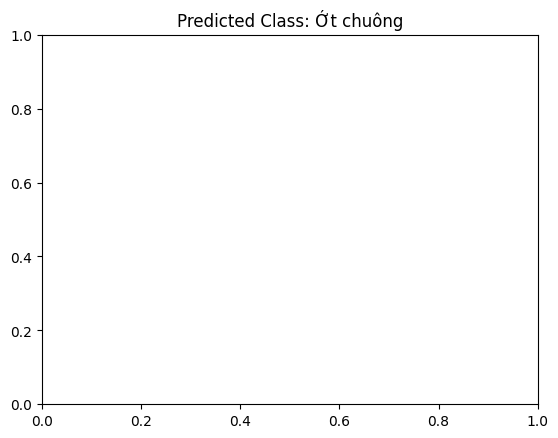

In [9]:
# Predict image path
image_path = r"D:\Graduation\Project\FinalDataset\Training\bell pepper\3.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make the prediction
prediction = model.predict(img_array)

# Get the predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]

# Print the predicted class
print("Predicted Class: ", predicted_class)

# Display the image
plt.show(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

In [8]:
model.save('D:\Graduation\Project\check_point\EfficientNet_model_30e.keras')

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Bước 1: Lấy nhãn thực tế và dự đoán
validation_generator.reset()  # Đảm bảo thứ tự dự đoán đúng với dữ liệu
y_true = validation_generator.classes  # Lấy nhãn thực tế
y_pred_prob = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
y_pred = y_pred_prob.argmax(axis=1)  # Lấy nhãn dự đoán

# Bước 2: Tính các giá trị đánh giá
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# In kết quả
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 119s 476ms/step
Accuracy: 0.8023115819889237
Precision: 0.806092781237167
Recall: 0.8023115819889237
F1: 0.7997845308119534
